# Simulate group size

Here we simulate the distribution of group sizes f(x)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
final_fig_path = "../Figures/"

In [44]:
f_of_x_vec.copy()

[1, 1]

In [264]:
'''
calls fun_dfdt for the different x's
params is a dictionary of the parameters
'''
def group_formation_model(f_of_x_vec,t,p,M1,M2,params):
    x_max = params["x_max"]
    dfdt = f_of_x_vec.copy() # making vector of same size, what's in it doesn't matter
    for x in range(2,x_max+1):
        dfdt[x-2] = fun_dfdt(f_of_x_vec, x, p, M1, M2, **params)
    return dfdt

'''
fun_dfdt: This calculates the change in the distribution f(x) wrt time for x >= 2


f(x) is the number of groups of size x
f_of_x_vec is a vector of f(x) for x = 2, .., x_max.

τx df/dt = -xf(x)ϕ(x) - f(1) f(x) ψ(x) - f(x) D(x) 
            + f(x+1)ϕ(x+1) + sum_{y=x+1}^{x_max} f(y) D(y)
            
TO-DO: What to do if x = x_max?
'''
def fun_dfdt(f_of_x_vec, x, p, M1, M2,  τx, δ, x_max, **params):

    # get f(x), f(1), and f(x+1)
    
    def f(y):
        if y == 1:
            return p - sum([z*f(z) for z in range(2,x_max+1)]) # this is recursively designed
        if y >= 2 and y <= x_max:
            return f_of_x_vec[y-2]
        else:
            return 0
        #return(fun_f_of_x(y,x_max,**params))

    def D_tot(y):
        return fun_1_death(y, τx, δ, **params)
    def D(z1,z2):
        # probability group of size z2 shrinks to group of size z1 for z1 \leq x_max  
        return fun_death_y_to_x(z1,z2, τx, δ, x_max, **params) if z2 <= x_max else 0
    def ϕ(y):
        # probability individual leaves group of size y for y <= x_max
        return fun_leave_group(y, M1, M2, x_max, **params) if y<= x_max else 0
    def ψ(y):
        return fun_join_group(y, M1, M2, x_max, **params) if y < x_max else 0
    
        
    individual_leaves = x*f(x) * ϕ(x)
    grows_to_larger_group = f(1)*f(x) * ψ(x)
    death_in_group = f(x) * D_tot(x)
    join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
    larger_grp_shrinks = (x+1)*f(x+1)*ϕ(x+1)
    death_in_larger_grp = sum([f(y)*D(x,y) for y in range(x+1,x_max+1)])
        
    #dfdt_times_taux = x*f_of_x*fun_leave_group(x) - 
    
    
    return 1/τx * (-individual_leaves - grows_to_larger_group - death_in_group  
                  + join_smaller_grp + larger_grp_shrinks + death_in_larger_grp)

'''

'''
def fun_f_of_x(y, f_of_x_vec, p, x_max,**params):
    if y == 1:
            return p - sum([z*f_of_x_vec[z-2] \
                            for z in range(2,x_max+1)]) 
    if y >= 2 and y <= x_max:
        return f_of_x_vec[y-2]
    else:
        return 0
    
'''
The probability an individual leaves a group of size x.
This is ϕ(x) in the text
FILL IN
'''
def fun_leave_group(x, M1, M2, x_max, **params):
    return best_response_fun(1,x,M1,M2,**params)

'''
The probability an individual joins a group of size x.
This is ψ(x) in the text
FILL IN
'''
def fun_join_group(x, M1, M2, x_max, **params):
    # deciding between being alone or being in a group of size x + 1
    return best_response_fun(x+1,1,M1,M2,**params)
'''
Compares W(x) to W(y) to "decide" on group size y or x
'''
def best_response_fun(x,y,M1,M2, d, **params):
    W_of_x = fun_fitness(x,M1,M2, **params)
    W_of_y = fun_fitness(y, M1, M2, **params)
    return W_of_x**d/(W_of_x**d + W_of_y**d)

def nchoosek(n,k):
    return sp.special.factorial(n)/(sp.special.factorial(k)*sp.special.factorial(n-k))

'''
The probability a group of size y shrinks to a group of size x because y - x individuals die, 
# works for for x < y, y <= x_max
'''
def fun_death_y_to_x(x, y, τx, δ, x_max, **params):
    
    return nchoosek(y,y-x) * (δ*τx)**(y-x)*(1-δ*τx)**x

def fun_1_death(x, τx, δ, **params):
    return 1 - (1 - δ*τx)**x


'''
this is the fitness of being in a group
for now we have a sigmoidal function of x multiplied by 1/x, 
indicating profits of being a group but then sharing
'''
def fun_fitness(x, M1, M2,b1, b2, r, γ,**params):
    wgroup = b1*fun_response(x,M1,M2,1,**params) + b2*fun_response(x,M1,M2,1,**params)
    if x > 1:
        repro_exchange = (1-γ)*(1-r) + r*x
        return 1/x*(wgroup) * repro_exchange
    else:
        return wgroup
    
def fun_response(x,M1,M2,index,a1,a2,h1,h2,**params):
    α1 = fun_attack_rate(x,1,**params)
    α2 = fun_attack_rate(x,2,**params)
    if index == 1:
        numerator = a1*α1*M1
    elif index == 2:
        numerator = a2*α2*M2
    denominator = 1 + a1*α1*h1*M1 + a2*α2*h2*M2
    return numerator/denominator

def fun_attack_rate(x, index, θ1, θ2, s1, s2, **params):
    if index == 1:
        return 1/(1 + np.exp(- θ1 * (x - s1)))
    elif index == 2:
        return 1/(1 + np.exp(- θ2 * (x - s2)))
    
def fun_num_groups(f_of_x_vec,p,x_max):
    total = 0
    for x in range(1,x_max+1):
        total += fun_f_of_x(x, f_of_x_vec, p, x_max,**dict())
    return total

'''
average group size any individual is in
this is not the same as the average group size
'''
def mean_group_size_membership(f_of_x_vec,p,x_max):
    total = sum([x**2*fun_f_of_x(x,f_of_x_vec,p,x_max,**dict()) \
                 for x in range(1,x_max+1)])
    
    return total/p
def mean_group_size_membership_not_solitary(f_of_x_vec,p,x_max):
    total = sum([x**2*fun_f_of_x(x,f_of_x_vec,p,x_max,**dict()) \
                 for x in range(2,x_max+1)])
    
    return total/p
def mean_group_size(f_of_x_vec,p,x_max):
    total = 0
    num_grps = 0
    for x in range(1,x_max+1):
        f_of_x = fun_f_of_x(x, f_of_x_vec, p, x_max,**dict())
        total += x * f_of_x
        num_grps += f_of_x
    return total/num_grps
        

In [267]:
x0

2

In [280]:
f_of_1 = fun_f_of_x(1, out[-1], p, **params)
f_of_1
full_f_vec = [f_of_1, *out[-1]]

k
r
b


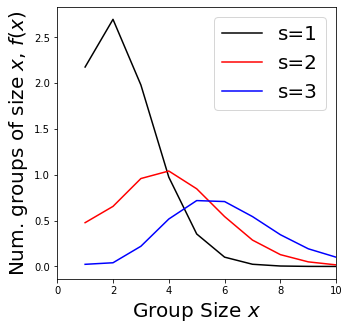

In [315]:
p = 20
M1 = 10; M2 = 10
f_of_x_vec = np.zeros(9)
params = dict(b1=1,b2=0.5,a1 = 1, a2 = 1, h1 = 2,h2 = 1, θ1 = 2, θ2 = -2, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0.5,γ=0, x_max=10, d = 2)


t = np.arange(0,2,0.02)
colors = ['k', 'r', 'b']
fig,ax  = plt.subplots(1,1,figsize = (5,5))
final_f_of_x = [0,0,0]
for i,s in enumerate([1,2,3]):
    params["s1"]=s
    params["s2"]=s
    out = odeint(group_formation_model,f_of_x_vec,t,args=(p, M1, M2, params))
    final_f_of_x[i] = out[-1]
    f_of_1 = fun_f_of_x(1, out[-1], p, **params)
    full_f_vec = [f_of_1, *out[-1]]
    print(colors[i])
    ax.plot(np.arange(1,11,1),full_f_vec,colors[i], label = 's=%d'%s)
ax.set_xlim([0,10])
ax.set_xlabel(r'Group Size $x$', fontsize = 20)
ax.set_ylabel(r'Num. groups of size $x$, $f(x)$', fontsize = 20)
ax.legend(fontsize = 20)


In [318]:
[mean_group_size_membership_not_solitary(f_vec,p=20,x_max=10) for f_vec in final_f_of_x]

[2.9131287344876884, 4.8401746153073315, 6.420080288748994]

In [323]:
label = r'$\theta_2=$'+'%d'

In [325]:
label %θ2

'$\\theta_2=$0'

In [340]:
''' 
changing a parameter value, but not x_max!!
len(param_vec must be 3)
example of linelabel: r'$\theta_2=$'+'%d'
param_key may be multiple keys, (the parameter version for big prey and small prey) 
    if they are being set to the same param value
'''
def plot_f_of_x(p, M1, M2,param_vec, param_key, linelabel, params, tsteps = 200, t_f = 2):

    x_max = params["x_max"]
    f_of_x_vec = np.zeros(x_max - 1)
    t = np.linspace(0,t_f,tsteps)
    colors = ['k','r','b']
    fig,ax = plt.subplots(1,1,figsize = (5,5))
    final_f_of_x = [0,0,0]
    for i, param in enumerate(param_vec):
        for pkey in param_key:
            params[pkey] = param
        out = odeint(group_formation_model,f_of_x_vec,t,args=(p, M1, M2, params))
        final_f_of_x[i] = out[-1]
        f_of_1 = fun_f_of_x(1, out[-1], p, **params)
        full_f_vec = [f_of_1, *out[-1]]
        ax.plot(np.arange(1,11,1),full_f_vec,colors[i], label = linelabel %param)
    ax.set_xlim([0,x_max])
    ax.set_xlabel(r'Group Size $x$', fontsize = 20)
    ax.set_ylabel(r'Num. groups of size $x$, $f(x)$', fontsize = 20)
    ax.legend(fontsize = 20)
    
    return fig, ax, [mean_group_size_membership_not_solitary(f_vec,p,x_max) for f_vec in final_f_of_x]

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='Group Size $x$', ylabel='Num. groups of size $x$, $f(x)$'>,
 [4.915125055922976, 4.72467015385182, 3.7580612991354334])

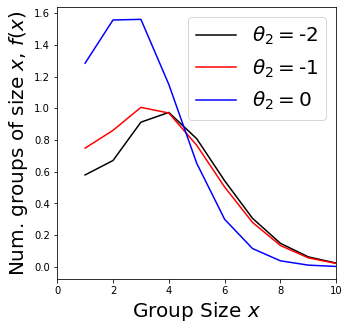

In [332]:
p = 20
M1 = 10; M2 = 10
params = dict(b1=1,b2=0.5,a1 = 1, a2 = 1, h1 = 2,h2 = 1, θ1 = 2, θ2 = -2, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0.5,γ=0.5, x_max=10, d = 2)





param_vec = [-2,-1,0]
param_key = "θ2"
linelabel = r'$\theta_2=$'+'%d'

plot_f_of_x(p, M1, M2,param_vec, param_key, linelabel, params, tsteps = 200, t_f = 2)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:xlabel='Group Size $x$', ylabel='Num. groups of size $x$, $f(x)$'>,
 [2.820899276983032, 4.915125055922976, 6.788381284843988])

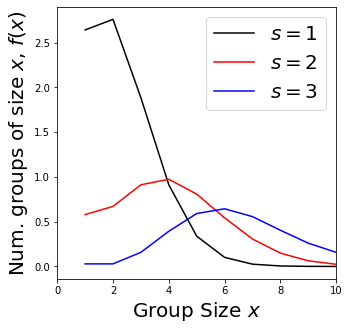

In [341]:
p = 20
M1 = 10; M2 = 10
params = dict(b1=1,b2=0.5,a1 = 1, a2 = 1, h1 = 2,h2 = 1, θ1 = 2, θ2 = -2, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0.5,γ=0.5, x_max=10, d = 2)

param_vec = [1,2,3]
param_key = ["s1", "s2"]
linelabel = r'$s=$'+'%d'

plot_f_of_x(p, M1, M2,param_vec, param_key, linelabel, params, tsteps = 200, t_f = 2)

In [343]:
def mean_grp_membership_versus_param(p, M1, M2,param_vec, param_key, params, tsteps = 200, t_f = 2):

    x_max = params["x_max"]
    f_of_x_vec = np.zeros(x_max - 1)
    t = np.linspace(0,t_f,tsteps)
    final_f_of_x = [0,0,0]
    for i, param in enumerate(param_vec):
        for pkey in param_key:
            params[pkey] = param
        out = odeint(group_formation_model,f_of_x_vec,t,args=(p, M1, M2, params))
        final_f_of_x[i] = out[-1]


    
    return np.array([mean_group_size_membership_not_solitary(f_vec,p,x_max) for f_vec in final_f_of_x])

In [ ]:
p = 20; M1 = 10; M2 = 10
params = dict(b1=1,b2=0.5,a1 = 1, a2 = 1, h1 = 2,h2 = 1, θ1 = 2, θ2 = -2, s1 = 2, s2 = 2,
             δ=0, τx=0.01, r=0.5,γ=0.5, x_max=10, d = 2)

param_key = "θ2"